# Install and import packages

In [25]:
!pip install biopython
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from collections import defaultdict
import itertools
from Bio import SeqIO

# Parse example.phy file

In [3]:
alignment = SeqIO.parse("example.phy", "phylip")
alignment = list(alignment)
for idx, record in enumerate(alignment):
 print(f"index: {idx}, id {record.id}, length: {len(record.seq)}, features: {len(record.features)}")

index: 0, id LngfishAu, length: 1998, features: 0
index: 1, id LngfishSA, length: 1998, features: 0
index: 2, id LngfishAf, length: 1998, features: 0
index: 3, id Frog, length: 1998, features: 0
index: 4, id Turtle, length: 1998, features: 0
index: 5, id Sphenodon, length: 1998, features: 0
index: 6, id Lizard, length: 1998, features: 0
index: 7, id Crocodile, length: 1998, features: 0
index: 8, id Bird, length: 1998, features: 0
index: 9, id Human, length: 1998, features: 0
index: 10, id Seal, length: 1998, features: 0
index: 11, id Cow, length: 1998, features: 0
index: 12, id Whale, length: 1998, features: 0
index: 13, id Mouse, length: 1998, features: 0
index: 14, id Rat, length: 1998, features: 0
index: 15, id Platypus, length: 1998, features: 0
index: 16, id Opossum, length: 1998, features: 0


In [4]:
subset = []
for record in alignment:
  sub = record.seq[:10]
  subset.append(sub)
  print(sub)

CTCCCACACC
CAACCACACC
CAACCACACC
AAATTTGGTC
CTTCCACACC
CTCCCACACC
CTTCCACACC
CTCCCACACC
CTACCACACC
CTACCACACC
CCACCACACC
CTACCACACC
CTACCACGCC
CTACCACACC
CTACCACACC
CCTCCACACC
CTTCCACACC


# Auxiliary functions to map words into indices in a vocabulary

In [5]:
def to_string(iterable, concat=''):
  return concat.join(iterable)

def get_vocab(size, alphabet):
  ret = {}
  ret2 = {}
  for idx, word in enumerate(itertools.product(alphabet, repeat=size)):
    word = to_string(word)
    ret[word] = idx
    ret2[idx] = word
  return ret, ret2

vocab2index, index2vocab = get_vocab(3, alphabet)
print(vocab2index)

{'GGG': 0, 'GGA': 1, 'GGT': 2, 'GGC': 3, 'GAG': 4, 'GAA': 5, 'GAT': 6, 'GAC': 7, 'GTG': 8, 'GTA': 9, 'GTT': 10, 'GTC': 11, 'GCG': 12, 'GCA': 13, 'GCT': 14, 'GCC': 15, 'AGG': 16, 'AGA': 17, 'AGT': 18, 'AGC': 19, 'AAG': 20, 'AAA': 21, 'AAT': 22, 'AAC': 23, 'ATG': 24, 'ATA': 25, 'ATT': 26, 'ATC': 27, 'ACG': 28, 'ACA': 29, 'ACT': 30, 'ACC': 31, 'TGG': 32, 'TGA': 33, 'TGT': 34, 'TGC': 35, 'TAG': 36, 'TAA': 37, 'TAT': 38, 'TAC': 39, 'TTG': 40, 'TTA': 41, 'TTT': 42, 'TTC': 43, 'TCG': 44, 'TCA': 45, 'TCT': 46, 'TCC': 47, 'CGG': 48, 'CGA': 49, 'CGT': 50, 'CGC': 51, 'CAG': 52, 'CAA': 53, 'CAT': 54, 'CAC': 55, 'CTG': 56, 'CTA': 57, 'CTT': 58, 'CTC': 59, 'CCG': 60, 'CCA': 61, 'CCT': 62, 'CCC': 63}


# Create numeric vectors for the aligments

In [6]:
def get_vectors(alignment, k, w, vocab2index, slider=1, one_batch=True):
  '''
  CBOW model for sequences

  input:
    alignment: parsed aligment, list of sequences
    k: int k-mer length for vocabulary
    w: int one-sided window length for context words
    vocab2index: match word to index for vocabulary
    slider: int for determining next k-mer
  return:
    xs: vector representation of central k-mers as training data
    ys: vector representation of context words for each central k-mer
  '''

  vocab_size = len(vocab2index)
  lena = len(alignment)

  current = 0
  while True:
    seq = alignment[current]
    length = len(seq)
    for start in range(w, length-w-k+1, slider):
      center = seq[start:start+k]
      left = seq[start-w:start]
      right = seq[start+k:start+k+w]
      x = np.zeros(vocab_size)
      c_idx = vocab2index.get(center)
      if c_idx is None:
        continue
      x[c_idx] = 1
      y = np.zeros(vocab_size)
      #print(left)
      #print(center)
      #print(right)
      idxs = [vocab2index.get(left[i:i+k]) for i in range(0, w-k+1, slider)]
      idxs += [vocab2index.get(right[i:i+k]) for i in range(0, w-k+1, slider)]
      idxs = [x for x in idxs if x is not None]
      if not idxs:
        continue
      for idx in idxs:
        y[idx] += 1
      y = y / len(idxs)
      yield x, y
    current += 1
    if current == lena:
      if one_batch:
        return
      current = 0

In [7]:
subset = []
for record in alignment:
  sub = record.seq[:12]
  subset.append(sub)
  print(sub)

alphabet = {"A", "C", "G", "T"}
vocab2index, index2vocab = get_vocab(2, alphabet)

for idx, (x, y) in enumerate(get_vectors(subset, 2, 3, vocab2index), 1):
  print (f"x: {x}; y: {y}")
print(f"Number of training examples: {idx}")

CTCCCACACCCC
CAACCACACCCC
CAACCACACCCC
AAATTTGGTCCT
CTTCCACACCCC
CTCCCACACCCC
CTTCCACACCCA
CTCCCACACCCC
CTACCACACCCC
CTACCACACCCC
CCACCACACCCC
CTACCACACCCC
CTACCACGCCCC
CTACCACACCCC
CTACCACACCCC
CCTCCACACCCC
CTTCCACACCCC
x: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]; y: [0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.25 0.   0.25
 0.25 0.  ]
x: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]; y: [0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.25 0.   0.25
 0.   0.25]
x: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]; y: [0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.
 0.   0.75]
x: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]; y: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25
 0.   0.75]
x: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]; y: [0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.25
 0.   0.5 ]
x: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]; y: [0.   0.   0.   0.   0. 

# Neural network functions

In [8]:
def initialize_model(n, v, random_seed=1):
  '''
  input:
    n: dimension of vector embedding
    v: vocabulary size
  return:
    W1: transformation matrix between input and hidden layer
    b1: bias between input and hidden layer
    W2: transformation matrix between hidden layer and output
    b2: bias between hidden layer and output
  '''

  np.random.seed(random_seed)

  W1 = np.random.rand(v,n)
  b1 = np.random.rand(1,n)
  W2 = np.random.rand(n,v)
  b2 = np.random.rand(1,v)

  return W1, b1, W2, b2

In [9]:
def softmax(z):
  return np.exp(z) / np.sum(np.exp(z), axis=0)

In [10]:
def forward_prop(x, W1, b1, W2, b2):
  '''
  input:
    x: training data m x v
  return:
    h: hidden layer m x n
    z: output layer m x v
  '''
  h = np.dot(x, W1) + b1

  # ReLU
  h[h < 0] = 0

  z = np.dot(h, W2) + b2

  return z, h

In [11]:
def cost_function(yhat, y):
  '''
  cross-entropy cost
  '''
  m = np.shape(y)[0]
  logprobs = np.multiply(np.log(yhat), y)
  cost = -1/m * np.sum(logprobs)
  cost = np.squeeze(cost)
  return cost

In [12]:
def backword_prop(x, W1, b1, h, W2, b2, z, yhat, y):

  m = np.shape(y)[0]
  aux = np.dot(yhat - y, W2.T)
  aux[aux <0 ] = 0

  grad_b2 = np.sum(yhat - y, axis=0) / m
  grad_b1 = np.sum(aux, axis=0) / m
  grad_W2 = np.dot(h.T, yhat-y) / m
  grad_W1 = np.dot(x.T, aux) / m 

  return grad_W1, grad_b1, grad_W2, grad_b2

In [13]:
def get_batches(alignment, k, w, vocab2index, slider=1, batch_size=128):
  '''
  input:
    alignment: parsed alignment, list of sequences
    k: int k-mer length for vocabulary
    w: int one-sided window length for context words
    vocab2index: match word to index in vocabulary
    slider: int for determining next k-mer
  '''
  batches_x = []
  batches_y = []
  for idx, (x, y) in enumerate(get_vectors(alignment, k, w, vocab2index, slider, False), 1):
    if not idx % batch_size:
      yield np.array(batches_x), np.array(batches_y)
      batches_x = []
      batches_y = []
    batches_x.append(x)
    batches_y.append(y)



In [48]:
def gradient_descent(alignment, k, w, n, alphabet, slider=1, alpha=0.03, batch_size=128, max_iter=1000):
  '''
  input:
    alignment: parsed aligment, list of sequences
    k: int k-mer length for vocabulary
    w: int one-sided window length for context words
    n: dimension of embedding
    alphabet: characters to create words
    slider: int for determining next k-mer
    alpha: learning parameter
  return:
    W1: transformation matrix between input and hidden layer
    b1: bias between input and hidden layer
    W2: transformation matrix between hidden layer and output
    b2: bias between hidden layer and output
  '''
  vocab2index, index2vocab = get_vocab(k, alphabet)
  v = len(vocab2index)

  iter = 0
  random_seed = 123
  W1, b1, W2, b2 = initialize_model(n, v)
  costs = []

  for x, y in get_batches(alignment, k, w, vocab2index, slider, batch_size):
    iter += 1
    if iter > max_iter:
      break
    z, h = forward_prop(x, W1, b1, W2, b2)
    yhat = softmax(z)

    
    #if not iter % (max_iter / 100):
    cost = cost_function(yhat, y)
    costs.append(cost)
    #  print(f"{iter}: {cost}")

    grad_W1, grad_b1, grad_W2, grad_b2 = backword_prop(x, W1, b1, h, W2, b2, z, yhat, y)

    W1 -= alpha * grad_W1
    b1 -= alpha * grad_b1
    W2 -= alpha * grad_W2
    b2 -= alpha * grad_b2

    if not iter % (max_iter / 10):
      alpha *= 0.66

  return W1, b1, W2, b2, costs

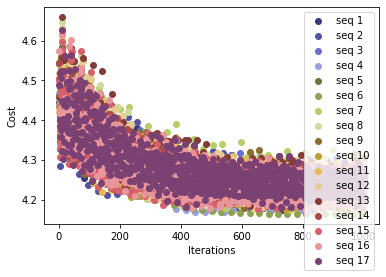

In [50]:
subset = []
alphabet = {"A", "C", "G", "T"}
fig, ax = plt.subplots()
colors = cm.get_cmap("tab20b").colors
ax.set_prop_cycle(color=colors)
for idx, record in enumerate(alignment):
  sub = record.seq[:10000]
  w1, b1, w2, b2, costs = gradient_descent([sub], 3, 3, 32, alphabet, alpha=0.03, max_iter=10**3, batch_size=64)
  ax.scatter(range(1, len(costs) + 1), costs, label=f"seq {idx + 1}")
  subset.append(sub)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()